In [1]:
import tensorflow as tf
import numpy as np
import sys
from optparse import OptionParser
import os
import utils as utl

def RNN(x, weights, biases, timesteps, num_hidden):

    
    # Unstack to get a list of 'timesteps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, timesteps, 1)

    # Define a lstm cell with tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden, forget_bias=1.0)
    # Get lstm cell output
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return outputs, states

In [2]:
# A: 5Day, 3:7
input_dir = 'data/15T'
timesteps = 480
num_input = 2
ckpt_dir = 'ckpt'

'''
#B: 5 Day 5:5
input_dir = 'data/15T_aug'
timesteps = 480
num_input = 2
ckpt_dir = 'ckpt_aug3'

#C: 10 Day
input_dir = 'data/10D15m'
timesteps = 720
num_input = 2
ckpt_dir = 'ckpt_10D_1'

#D: 15 Day
input_dir = 'data/15D15m'
timesteps = 960
num_input = 2
ckpt_dir = 'ckpt_15D_1'

'''


X = np.fromfile(input_dir + '/X.dat', dtype=float)
cardinality = int(X.shape[0]/(timesteps * num_input))
X = X.reshape([cardinality, timesteps, num_input])
Y = np.fromfile(input_dir + '/Y.dat', dtype=float)






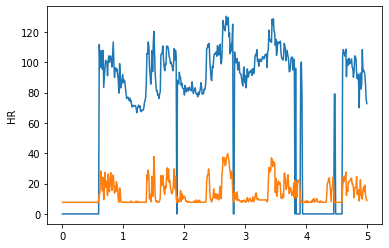

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

axis = np.arange(0., 5., 5/480)
hr = X[0].reshape([2,480])[0]
act = X[0].reshape([2,480])[1]*10
plt.plot(axis, hr, axis, act)
plt.ylabel('HR')
plt.show()

In [4]:
train_x, val_x, test_x, train_y, val_y, test_y = utl.train_val_test_split(X, Y, split_frac=0.80)

# Training Parameters
learning_rate = 0.001
epochs =800 
batch_size = 40
#display_step = 200

# Network Parameters
#num_input = 2 
#timesteps = 480 
num_hidden = 1024 
num_classes = 1

print("### Network Parameters ###")
print("Learning Rate: {}".format(learning_rate))
print("Batch Size: {}".format(batch_size))
print("Size of Hidden Layer: {}".format(num_hidden))
print("Timestep: {}".format(timesteps)) 
print("------------------")
X_ = tf.placeholder("float", [None, timesteps, num_input])
Y_ = tf.placeholder("float", [None, num_classes])
lr = tf.placeholder("float")

weights = {
    'out':tf.Variable(tf.random_normal([num_hidden,num_classes]))
}
biases = {
    'out':tf.Variable(tf.random_normal([num_classes]))
}

outputs, states = RNN(X_, weights, biases, timesteps, num_hidden)
prediction = tf.matmul(outputs[-1], weights['out']) + biases['out']

loss_op = tf.losses.mean_squared_error(Y_, prediction)
#optimizer = tf.train.AdadeltaOptimizer(lr).minimize(loss_op)
#optimizer = tf.train.AdamOptimizer(lr).minimize(loss_op)
optimizer = tf.train.GradientDescentOptimizer(lr).minimize(loss_op)

correct_pred = tf.equal(tf.cast( (prediction/1.8) - tf.round(prediction/1.8), tf.float32), tf.cast( (prediction/1.8)-tf.round(Y_/1.8), tf.float32))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Restore the ckpt
SAVER_DIR = ckpt_dir 
saver = tf.train.Saver()
checkpoint_path = os.path.join(SAVER_DIR, SAVER_DIR)
ckpt = tf.train.get_checkpoint_state(SAVER_DIR)

### Network Parameters ###
Learning Rate: 0.001
Batch Size: 40
Size of Hidden Layer: 1024
Timestep: 480
------------------
Instructions for updating:
Colocations handled automatically by placer.

For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Use tf.cast instead.


In [7]:

init = tf.global_variables_initializer()

with tf.Session() as sess:
    #new_saver = tf.train.import_meta_graph('ckpt.meta')
    saver.restore(sess, ckpt.model_checkpoint_path) 
    
    Out_, Stat_, Pred_ = sess.run([outputs, states, prediction], feed_dict = {X_:X, Y_:Y[:, None]})
    print(Out_[0])
    print(Stat_[0])
    print(Pred_[0])
    tmp = weights['out'].eval()
#     print("loss test: %f" % loss_op.eval(feed_dict = {X_:test_x, Y_:test_y[:, None]}))
#     pred = np.array(prediction.eval(feed_dict = {X_:X, Y_:Y[:, None]}))
#     pred_diagnosis = [1 if x[0]>=1.8 else 0 for x in list(pred)]
#     y_diagnosis = [1 if x>=1.8 else 0 for x in list(Y)]
    
#     evaluation = np.equal(pred_diagnosis, y_diagnosis)
#     print(np.mean(evaluation))
#     f = open('result.txt', 'w')
#     for i in range(0, len(Y)):
#         f.write(str(pred[i][0]) + ', ' + str(Y[i])+'\n')
#     f2 = open('result_diagnosis.txt', 'w')
#     for i in range(0, len(Y)):
#         f2.write(str(pred_diagnosis[i]) + ', ' + str(y_diagnosis[i])+'\n')
#     f2.close()
#     f.close()

INFO:tensorflow:Restoring parameters from ckpt/ckpt
[[ 4.4477116e-02 -2.9619711e-02  4.2323634e-02 ... -1.3009407e-02
  -1.3128286e-02 -4.2699404e-02]
 [ 1.9082060e-02 -5.3343032e-02  6.8779278e-01 ... -7.6084125e-01
  -3.7180580e-05 -1.3150464e-02]
 [ 1.7054765e-02 -5.4250363e-02  6.9167411e-01 ... -7.6076812e-01
  -3.4200391e-05 -1.2047559e-02]
 ...
 [ 1.7650964e-02 -6.2761359e-02  6.8987387e-01 ... -7.6025313e-01
  -5.2566251e-05 -1.3149965e-02]
 [ 9.6507147e-03 -5.3826578e-02  7.0841181e-01 ... -7.6047754e-01
  -1.8068326e-05 -7.5204526e-03]
 [ 1.7354129e-02 -4.8911810e-02  6.9146103e-01 ... -7.6101077e-01
  -2.6494994e-05 -1.1734140e-02]]
[[ 1.9509591  2.226983   5.0044255 ... -4.9722385  2.1274679 -2.0696282]
 [ 1.9514432  2.2115638  5.0147357 ... -5.009653   2.0666013 -2.0315394]
 [ 1.9398402  2.2764769  4.9641113 ... -4.9113193  2.191247  -2.033969 ]
 ...
 [ 1.941115   2.2773998  4.965676  ... -4.912572   2.1997309 -2.044206 ]
 [ 1.9405363  2.2821083  4.960899  ... -4.8993306  

In [9]:
    tmp.shape

(1024, 1)

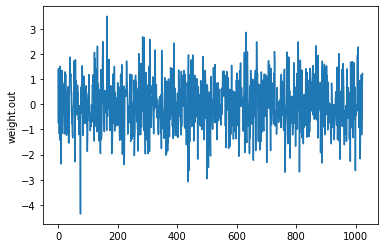

In [11]:


plt.plot(tmp)
plt.ylabel('weight.out')
plt.show()

In [16]:
np.matmul(tmp.reshape([1,1024]), Stat_.h[0])

array([2.9150012], dtype=float32)

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`